In [1]:
import os
import warnings
import mne
warnings.filterwarnings("ignore")

# os.chdir(".")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet, NBeats
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MQF2DistributionLoss, QuantileLoss

from sklearn.preprocessing import normalize
import seaborn as sns

torch.cuda.set_device(2) 
# torch.multiprocessing.set_start_method('spawn')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:


# load data
file = "physionet.org/files/adfecgdb/1.0.0/r04.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# after normalization 
raw_data = normalize(raw_data,axis=1,norm="max")
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /home/amirsalimi/ECG_Nexting/physionet.org/files/adfecgdb/1.0.0/r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [39]:
lead = 0 
c = raw_data[lead]
c = c.reshape([200,-1])
ts = np.array(c.shape[0] * [list(range(c.shape[1]))])
series = np.concatenate(np.array([c.shape[1]*[x] for x in range(c.shape[0])]))
data = pd.DataFrame(data = {"value":np.concatenate(c),"time_idx":np.concatenate(ts),"series":series})
data["series"] = data["series"].astype("str")
c.shape

(200, 1500)

In [58]:
# create dataset and dataloaders
max_encoder_length = 500
max_prediction_length = 200

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    static_categoricals=[
        "series"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0,
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, 
)

In [59]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(1.0507)

In [70]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(gpus=0, gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training, learning_rate=3e-2, hidden_size=100, rnn_layers=3, loss=MultivariateNormalDistributionLoss(rank=30)
)

Global seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=2` reached.
LR finder stopped early after 2 steps due to diverging loss.
Restoring states from the checkpoint path at /home/amirsalimi/ECG_Nexting/.lr_find_30fe4e9b-14e6-483f-9c87-7f323f9ee300.ckpt
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.


suggested learning rate: None


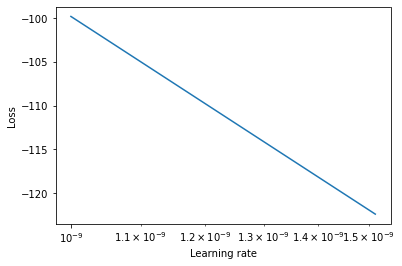

Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.


In [71]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-9,
    max_lr=1,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [72]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=300,
    gpus=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=0.001,
    log_interval=10,
    log_val_interval=1,
    hidden_size=500,
    rnn_layers=3,
#     loss=MultivariateNormalDistributionLoss(rank=30),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 6.2 K 
3 | rnn                    | LSTM                   | 5.1 M 
4 | distribution_projector | Linear                 | 1.0 K 
------------------------------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.333    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [53]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [54]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.0278)

In [55]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

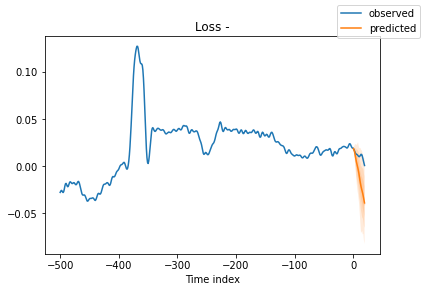

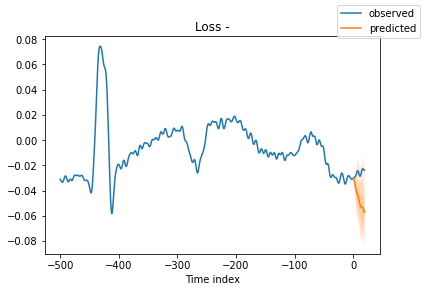

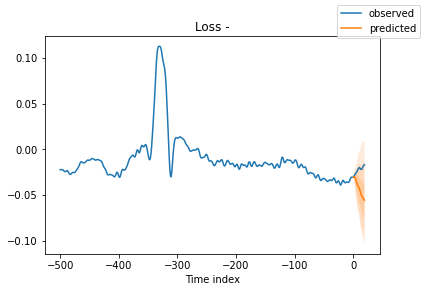

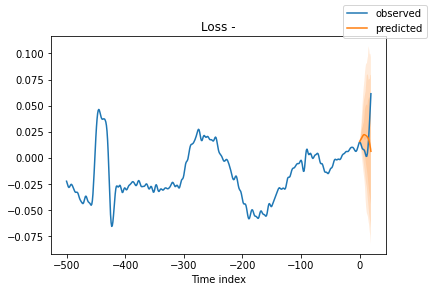

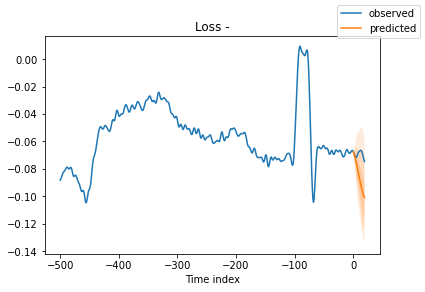

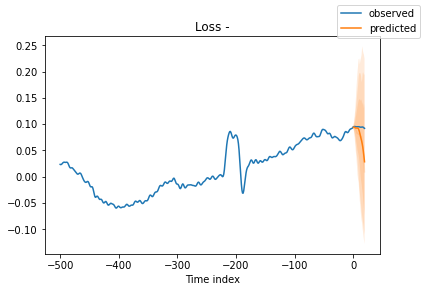

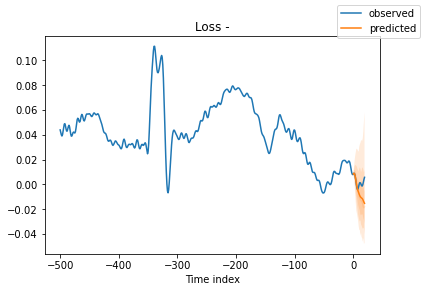

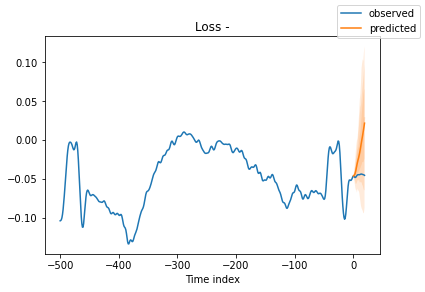

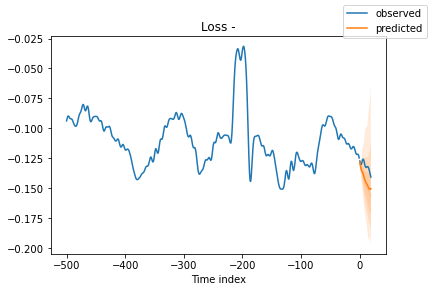

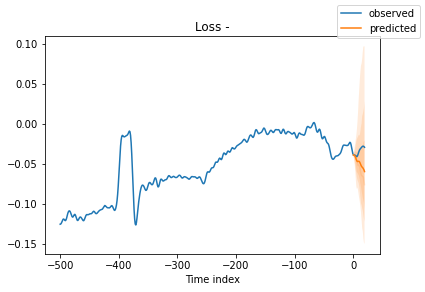

In [56]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);


In [57]:
for idx in range(10):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx);

AttributeError: 'DeepAR' object has no attribute 'plot_interpretation'